# Feature extraction and reverse image search

This notebook will guide you through the procedure of analyzing a large set of images using a pre-trained convolutional network, extracting feature vectors for each one which represent each image. 

After the analysis is done, we will review some retrieval tasks that you can do with such an analysis. The main task will be that of "reverse image search," which refers to searching for the most similar set of images to some query image. 

For an introduction into feature extraction, see the previous notebook `feature_extraction.ipynb`.

### Prepare a dataset

You will need a folder of images to analyze. There is no limit to the size of the dataset, but for good results, at least 1000 would be good.

This notebook will use an example dataset called [Caltech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), which contains roughly 9000 images in 101 categories. You may have already downloaded this dataset from the previous notebook, `7a_transfer_learning.ipynb`. If not, please download it from [here](http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz) and unzip it into the `data` folder, or just run the following commands in a terminal from the folder this notebook is in.

    wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
    tar -xvzf 101_ObjectCategories.tar.gz
    
You may use a custom folder of images (which may have subfolders) instead if you wish.

We'll start by importing the relevant Keras libraries that we'll be using.

In [1]:
# This only works on Colab?
#%tensorflow_version 1.x

In [2]:
# Let's look at the GPU processor we're running
#!nvidia-smi

In [3]:
import os

import random
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

import keras
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.decomposition import PCA
from sklearn import metrics
from scipy.spatial import distance

We will load a previously-trained neural network, that of VGG16, which comes with Keras. If it's your first time loading it, it will automatically download the weights for you, which will take some time. Afterwards, the weights will be cached locally for future use. Keras has a number of other [pre-trained networs](https://keras.io/applications/) which you can try as well.

In [4]:
model = VGG16(weights='imagenet', include_top=True)

2022-03-01 01:45:29.049658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 01:45:29.079237: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 01:45:29.079394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-01 01:45:29.080205: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Let's look at the model summary to see how it's structured.

In [5]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [6]:
# If running on Colab, need to import drive

#from google.colab import drive
#drive.mount('/content/gdrive')

In [7]:
# Let's see what categories of pictures are in dataset
# Note:  removed Google background and Faces_easy
!ls ./gdrive/MyDrive/101_ObjectCategories

accordion				   inline_skate
airplanes				   joshua_tree
all					   kangaroo
anchor					   ketch
ant					   lamp
barrel					   laptop
bass					   Leopards
beaver					   llama
binocular				   lobster
bonsai					   lotus
brain					   mandolin
brontosaurus				   mayfly
buddha					   menorah
butterfly				   metrics300_4000.p
CalTechFeatures.p			   metrics300.p
CalTechFeatures.p.justPca		   metrics.p
camera					   metronome
cannon					   minaret
car_side				   Motorbikes
ceiling_fan				   nautilus
cellphone				   octopus
chair					   okapi
chandelier				   pagoda
cougar_body				   panda
cougar_face				   pigeon
crab					   pizza
crayfish				   platypus
crocodile				   pyramid
crocodile_head				   revolver
cup					   rhino
dalmatian				   rooster
dollar_bill				   saxophone
dolphin					   schooner
dragonfly				   scissors
electric_guitar				   scorpion
elephant				   sea_horse
emu					   snoopy
euphonium				   soccer_ball
ewer					   stapler
Faces					   starfish
features-caltech101-resnet-c

The summary gives us a layer-by-layer description of the network. Notice that VGG16 is a deep network with 13 convolutional layers. It was previously trained on millions of images, and has over 100,000,000 weights and biases, the majority of which connect to the first fully-connected layer (fc1). VGG-16 is setup to take a fixed-size (224 x 224 x 3) RGB image at its input, and then forward it through a series of altrnating convolutional and max-pooling layers, then capped off by three fully-connected layers of 4096, 4096, and 1000 neurons, where the last layer is our softmax classification layer.

Notice that the output shape at each layer has `None` the first dimension. This is because the network can process multiple images in a single batch. So if you forward 5 images at shape [5, 224, 224, 3], then the output shape at each layer will be 5 in the first dimension.

### Forwarding an image through the network

In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size. To help us do this, we will create a function `load_image(path)` which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [8]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

We'll load an image and take a look at its data vector.

image_0001.jpg	image_0012.jpg	image_0023.jpg	image_0034.jpg	image_0045.jpg
image_0002.jpg	image_0013.jpg	image_0024.jpg	image_0035.jpg	image_0046.jpg
image_0003.jpg	image_0014.jpg	image_0025.jpg	image_0036.jpg	image_0047.jpg
image_0004.jpg	image_0015.jpg	image_0026.jpg	image_0037.jpg	image_0048.jpg
image_0005.jpg	image_0016.jpg	image_0027.jpg	image_0038.jpg	image_0049.jpg
image_0006.jpg	image_0017.jpg	image_0028.jpg	image_0039.jpg	image_0050.jpg
image_0007.jpg	image_0018.jpg	image_0029.jpg	image_0040.jpg	image_0051.jpg
image_0008.jpg	image_0019.jpg	image_0030.jpg	image_0041.jpg	image_0052.jpg
image_0009.jpg	image_0020.jpg	image_0031.jpg	image_0042.jpg	image_0053.jpg
image_0010.jpg	image_0021.jpg	image_0032.jpg	image_0043.jpg	image_0054.jpg
image_0011.jpg	image_0022.jpg	image_0033.jpg	image_0044.jpg
shape of x:  (1, 224, 224, 3)
data type:  float32


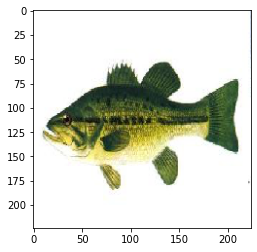

In [9]:
!ls ./gdrive/MyDrive/101_ObjectCategories/bass
img, x = load_image("./gdrive/MyDrive/101_ObjectCategories/bass/image_0005.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

The shape of the image is [1, 224, 224, 3]. The reason it has the extra first dimension with 1 element is that the network can take batches of images to process them all simultaneously. So for example, 10 images can be propagated through the network if `x` has a shape of [10, 224, 224, 3].

Let's get class predictions from this model. We forward `x` through `model` and then use the built-in `decode_predictions` to look up the class names.

In [10]:
# forward the image through the network
predictions = model.predict(x)

# print out the estimates of object type
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

2022-03-01 01:45:31.702210: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8302
2022-03-01 01:45:32.095801: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


predicted tench with probability 0.261
predicted barracouta with probability 0.245
predicted triceratops with probability 0.184
predicted rock_beauty with probability 0.086
predicted reel with probability 0.025


### Feature extraction

What we have in the `model` variable is a highly effective image classifier trained on the ImageNet database. We expect that the classifier must form a very effective representation of the image in order to be able to classify it with such high accuracy. We can use this to our advantage by re-purposing this for another task.

What we do is we copy the model, but remove the last layer (the classification layer), so that the final layer of the new network, called `feat_extractor` is the second 4096-neuron fully-connected layer, "fc2 (Dense)".

The way we do this is by instantiating a new model called `feature_extractor` which takes a reference to the desired input and output layers in our VGG16 model. Thus, `feature_extractor`'s output is the layer just before the classification, the last 4096-neuron fully connected layer. It looks like a copy, but internally, all Keras is doing is making a pointer to each of these layers and not actually copying anything. Thus, the output "prediction" from `feat_extractor` will just be the layer `fc2` from `model`.

If we run the `summary()` function again, we see that the architecture of `feat_extractor` is identical to the original `model`, except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [11]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Now let's see the feature extractor in action. We pass the same image from before into it, and look at the results. The `predict` function returns an array with one element per image (in our case, there is just one). Each element contains a 4096-element array, which is the activations of the last fully-connected layer `fc2` in VGG16. Let's plot the array as well.

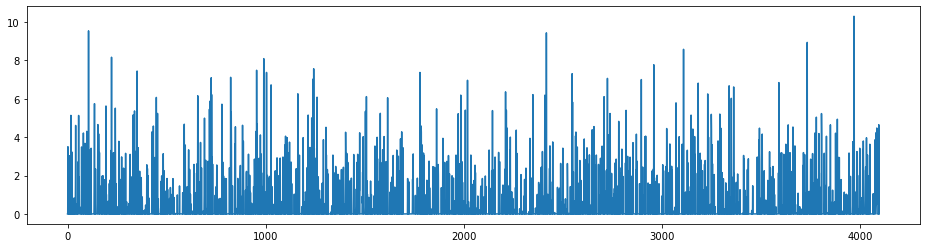

In [12]:
img, x = load_image("./gdrive/MyDrive/101_ObjectCategories/bass/image_0005.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

Our expectation is that the `fc2` activations form a very good representation of the image, such that similar images should produce similar activations. In other words, the `fc2` activations of two images which have similar content should be very close to each other. We can exploit this to do information retrieval. 

In the next cell, we will open a folder of images for analysis. First, the next cell will just recursively crawl the folder specified by `image_path` looking for images of the extensions inside of `image_extensions` and then limiting them to a random subset of maximum `max_num_images` images. Change these variables if you wish to change the target images.

In [13]:
def getClosestPerImage(images, imageToCategory, pca_feats, N=5):

    # Return the top N *closest* images for each image
    t0 = time.time()

    closestForImagePath = {}
    for i, image_path in enumerate(images):
        # Find category of query image
        queryCategory=imageToCategory[image_path]

        # Get N closest images and store in dictionary
        idx_closest = get_closest_images(i, pca_feats, N)
        closestForImagePath[image_path] = idx_closest

        if i % 500 == 0:
            print("analyzing image %d / %d" % (i, len(images)))

    elap = time.time() - t0;
    print("Total time: %5.4f seconds." % elap)

    return closestForImagePath

def get_closest_images(query_image_idx, pca_feat, num_results=5):
    distances = [ distance.cosine(pca_feat[query_image_idx], feat) for feat in pca_feat ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


In [14]:
# Instead of running the code segments below, if it is saved out, you can load from pickle
# file 'CalTechFeatures.p' and 'metrics300_4000.p' as shown in this cell

#from google.colab import drive (otherwise update path)
#drive.mount('/content/gdrive')

loadFromFile = False
if loadFromFile:
    [images, pca_features, pca, pca_features_full, pcaFull, imageToCategory] = pickle.load(open('./gdrive/MyDrive/101_ObjectCategories/CalTechFeatures.p', 'rb'))
    [closestForImagePathFull, closestForImagePath] = pickle.load(open('./gdrive/MyDrive/101_ObjectCategories/metrics300_4000.p', 'rb'))
else:
    images_path = './gdrive/MyDrive/101_ObjectCategories'
    image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
    max_num_images = 10000

    images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
    if max_num_images < len(images):
        images = [images[i] for i in sorted(random.sample(xrange(len(images)), max_num_images))]

    print("keeping %d images to analyze" % len(images))

    imageToCategory = {}
    for i in range(len(images)):
        paths = images[i].split('/')
        imageToCategory[images[i]] = paths[4]

    print(len(imageToCategory))

    t0 = time.time()
    tLast = t0

    features = []
    for i, image_path in enumerate(images):
        if i % 500 == 0:
            tNow = time.time()
            elap = tNow-tLast;
            tLast = tNow
            print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        img, x = load_image(image_path);
        feat = feat_extractor.predict(x)[0]
        features.append(feat)

    elap = tNow-t0;
    print('finished extracting features for %d images' % len(images))
    print("Total time: %5.4f seconds." % elap)

    features = np.array(features)
    pca = PCA(n_components=300)
    pca.fit(features)

    # For future comparison, let's look at larger feature vector
    pcaFull = PCA(n_components=4000)
    pcaFull.fit(features)

    pca_features = pca.transform(features)
    print(pca_features.shape)

    pca_features_full = pcaFull.transform(features)
    print(pca_features_full.shape)
    
    # Save to file
    pickle.dump([images, pca_features, pca, pca_features_full, pcaFull, imageToCategory], open('./gdrive/MyDrive/101_ObjectCategories/CalTechFeatures.p', 'wb'))

    # Now get closest
    closestForImagePath = getClosestPerImage(images, imageToCategory, pca_features, N=5)
    closestForImagePathFull = getClosestPerImage(images, imageToCategory, pca_features_full, N=5)

    # Save to file
    pickle.dump([closestForImagePathFull, closestForImagePath], open('./gdrive/MyDrive/101_ObjectCategories/metrics300_4000.p', 'wb'))

print(dir())
print(len(images))

keeping 7442 images to analyze
7442
analyzing image 0 / 7442. Time: 0.0000 seconds.
analyzing image 500 / 7442. Time: 17.0762 seconds.
analyzing image 1000 / 7442. Time: 17.3875 seconds.
analyzing image 1500 / 7442. Time: 17.5296 seconds.
analyzing image 2000 / 7442. Time: 17.3528 seconds.
analyzing image 2500 / 7442. Time: 17.4633 seconds.
analyzing image 3000 / 7442. Time: 17.3315 seconds.
analyzing image 3500 / 7442. Time: 17.4669 seconds.
analyzing image 4000 / 7442. Time: 17.5139 seconds.
analyzing image 4500 / 7442. Time: 17.4282 seconds.
analyzing image 5000 / 7442. Time: 17.4713 seconds.
analyzing image 5500 / 7442. Time: 17.5107 seconds.
analyzing image 6000 / 7442. Time: 17.3881 seconds.
analyzing image 6500 / 7442. Time: 17.8016 seconds.
analyzing image 7000 / 7442. Time: 17.7829 seconds.
finished extracting features for 7442 images
Total time: 244.5044 seconds.
(7442, 300)
(7442, 4000)
analyzing image 0 / 7442
analyzing image 500 / 7442
analyzing image 1000 / 7442
analyzing

Alone, these activations provide a good representation, but it is a good idea to do one more step before using these as our feature vectors, which is to do a [principal component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) to reduce the dimensionality of our feature vectors down to 300. We apply PCA for two reasons: 1) the 4096-bit feature vector may have some redundancy in it, such that multiple elements in the vector are highly correlated or similar. This would skew similarity comparisons towards those over-represented features. 2) Operating over 4096 elements is inefficient both in terms of space/memory requirements and processor speed, and it would be better for us if we can reduce the length of these vectors but maintain the same effective representation. PCA allows us to do this by reducing the dimensionality down of the feature vectors from 4096 to much less, but maintain a representation which is still faithful to the original data, by preserving the relative inter-point distance.

Thus, PCA reduces the amount of redundancy in our features (from duplicate or highly-correlated features), speeds up computation over them, and reduces the amount of memory they take up.

The next cell will instantiate a `PCA` object, which we will then fit our data to, choosing to keep the top 300 principal components. This may take a few minutes.

Now let's see what the PCA version of the feature vector above looks like.

(1, 4096)
(1, 300)
(1, 224, 224, 3)
schooner


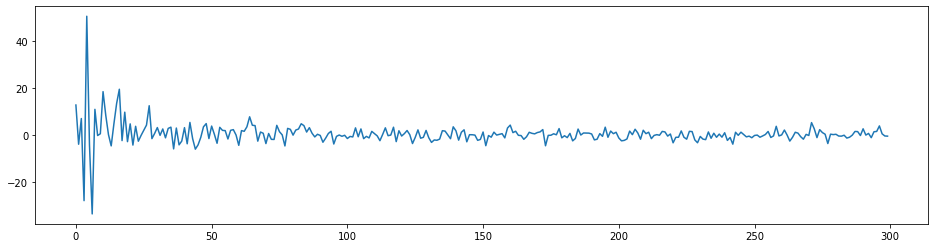

In [15]:
# Jump to here if loading features from pickle file

#thisImage = "./gdrive/MyDrive/101_ObjectCategories/bass/image_0005.jpg"
thisImage = images[0]
img, x = load_image(thisImage)
this_feat = feat_extractor.predict(x)
print(this_feat.shape)
this_pca = pca.transform(this_feat)
print(this_pca.shape)
print(x.shape)
print(imageToCategory[thisImage])

plt.figure(figsize=(16,4))
plt.plot(this_pca[0])

We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Let's pick a random query image.

7442
<class 'dict'>
<class 'list'>
7442
573
llama


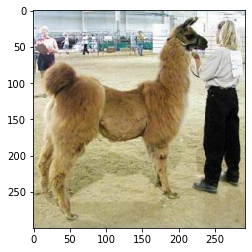

In [16]:

print(len(imageToCategory))
print(type(imageToCategory))
print(type(images))
print(len(images))

# grab a random query image
query_image_idx = int(len(images) * random.random())
print(query_image_idx)
print(imageToCategory[images[query_image_idx]])

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

The assumption we can now make is that two images which have similar content, should produce similar feature vectors. The next two cells will randomly select one image, and then compute a measurement of the dissimilarity (or distance) of that image's PCA feature vector to every other image's feature vector. The dissimilarity metric we use is [cosine distance](https://en.wikipedia.org/wiki/Cosine_similarity). 

In [17]:
similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

The list `similar_idx` contains the image's similarity to every other one. We can sort that list and find the indexes of the most similar images. The next cell will sort them, and then find the most similar items, and return the indexes 5 most similar images. Notice we take from indexes 1:6 rather than 0:5 because the most similar image to the query image, will trivially be the query image itself, since it is included in the distance calculation. So we just skip it.

In [18]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

The next cell opens the images specified by `idx_closest` and concatenates them into a single image (resizing each so it has a height of 100 pixels.

llama
llama
llama
llama
llama


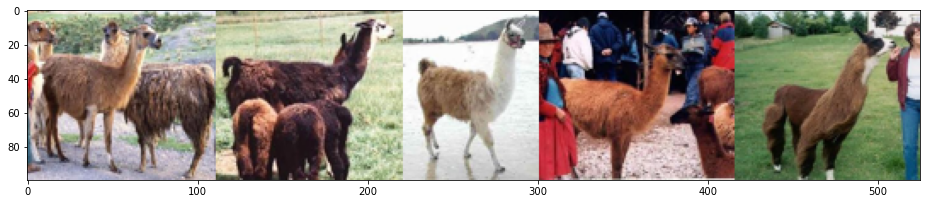

In [19]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    print(imageToCategory[images[idx]])
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)


For convenience, we'll automate this process by defining the function `get_closest_images`, which will compute the cosine distance between the PCA features of `query_image_idx`-th image in our dataset, and the PCA features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the `num_results` (default is 5) most similar images to it (not including itself). 

We also define a helper function `get_concatenated_images` which will simply take those resulting images and concatenate them into a single image for easy display.

In [20]:
def get_closest_images(query_image_idx, num_results=5):
    distances = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image


So now we can do our lookups like this:

query category= crab
   match category= crab
   match category= scorpion
   match category= crab
   match category= tick
   match category= tick


Text(0.5, 1.0, 'result images')

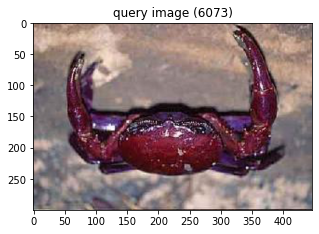

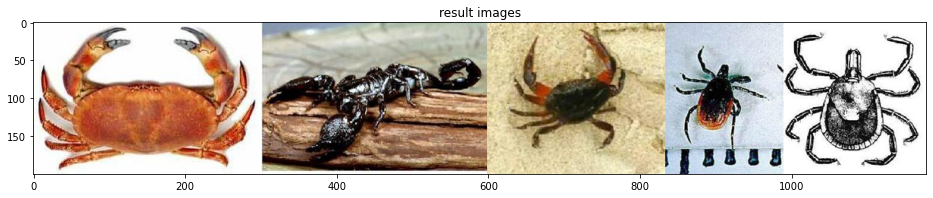

In [21]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
print('query category=', imageToCategory[images[query_image_idx]])
idx_closest = get_closest_images(query_image_idx)
for ii in idx_closest:
  print('   match category=', imageToCategory[images[ii]])

query_image = get_concatenated_images([query_image_idx], 300)
results_image = get_concatenated_images(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

In [22]:
def computeMetrics (y_true, y_pred):

    # Create empty object to hold results
    stats = lambda:0

    stats.mac = metrics.precision_score(y_true, y_pred, average='macro')
    stats.mic = metrics.recall_score(y_true, y_pred, average='micro')
    stats.f1 = metrics.f1_score(y_true, y_pred, average='macro')
    stats.wei = metrics.f1_score(y_true, y_pred, average='weighted')
    stats.beta = metrics.fbeta_score(y_true, y_pred, average='macro', beta=0.5)
    
    return stats

In [23]:
y_true = []
y_pred = []

for image_path in images:
    cat1 = imageToCategory[image_path]
    closest = closestForImagePath[image_path]
    for i in closest:
        y_true.append(cat1)
        y_pred.append(imageToCategory[images[i]])

stats = computeMetrics(y_true, y_pred)

print('Precision=', stats.mac)
print('Recall=', stats.mic)
print('F1 score=', stats.f1)
print('Weighted F1=', stats.wei)
print('Beta=', stats.beta)

Precision= 0.8084255219000089
Recall= 0.854555227089492
F1 score= 0.8007957282111389
Weighted F1= 0.8504867111749373
Beta= 0.8043175561621111
